### Generate figures that tell a story about feature value entropy (confidence)

In [6]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load units with highest correlation to feature entropy

In [22]:
correlations = pd.read_pickle("/data/patrick_res/glm_2/feat_entropy_correlations_cond_inc.pickle")
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
positions = spike_utils.get_unit_positions(sessions)
correlations = pd.merge(correlations, positions, on=["PseudoUnitID", "session", "UnitID"])
correlations["r_mag"] = correlations.r_value.abs()

In [23]:
correlations.sort_values(by="r_mag", ascending=False)[:10][["PseudoUnitID", "r_value", "structure_level2"]]

,PseudoUnitID,r_value,structure_level2
515,2018100902,0.308303,anterior_cingulate_gyrus (ACgG)
554,2018092107,0.282447,inferior_temporal_cortex (ITC)
580,2018091710,-0.244125,basal_ganglia (BG)
176,2018080611,0.221942,lateral_prefrontal_cortex (lat_PFC)
667,2018071213,-0.219971,lateral_prefrontal_cortex (lat_PFC)
43,2018070943,0.218836,basal_ganglia (BG)
668,2018071214,0.213455,lateral_prefrontal_cortex (lat_PFC)
50,2018092006,0.206171,inferior_temporal_cortex (ITC)
670,2018071216,-0.204223,lateral_prefrontal_cortex (lat_PFC)
701,2018071247,-0.203038,amygdala (Amy)


In [25]:
SMOOTH = 1
num_bins = 10
mode = "FiringRate"
plt.rcParams.update({'font.size': 14})


def visualize_correlations(row, interesting_feats=[], by_dims=False):
    session = row.session

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")



    beh = behavioral_utils.get_feature_values_per_session(session, beh)
    beh = behavioral_utils.get_relative_block_position(beh, num_bins)
    beh = behavioral_utils.get_max_feature_value(beh, num_bins, quantize_bins=True)
    beh = behavioral_utils.calc_feature_probs(beh)
    beh = behavioral_utils.calc_feature_value_entropy(beh, num_bins, quantize_bins=False)

    beh = behavioral_utils.get_prev_choice_fbs(beh)
    beh = beh[beh.PrevResponse == "Incorrect"]
    
    # define confidence as normalized entropy
    conf = 1 / beh["FeatEntropy"]
    beh["Confidence"] = (conf - conf.min()) / (conf.max() - conf.min())
    beh["Confidence Bin"], labels = pd.qcut(beh["Confidence"], num_bins, labels=False, retbins=True)
    beh["Confidence Bin"] = labels[beh["Confidence Bin"]]
    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"

    frs = pd.read_pickle(fr_path)
    frs = frs[frs.UnitID == row.UnitID]
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
    merged = pd.merge(agg, beh, on="TrialNumber")

    fig, axs = plt.subplots(2, 1, figsize=(6, 10))
    ax = axs[0]
    sns.lineplot(merged, x="Confidence Bin", y="FiringRate", ax=ax)
    ax.set_xticks([]) 
    ax.set_xlabel(None)
    # visualization_utils.plot_mean_sterrs_by_block_pos(beh, "MaxValue", ax, row.PseudoUnitID, num_block_bins)
    ax.set_ylabel("Firing Rate")
    # ax.set_title(f"{row.structure_level2}: {row.PseudoUnitID}")

    ax = axs[1]
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged["Confidence"], merged[mode])
    ax.scatter(merged["Confidence"], merged[mode], alpha=0.15, color="black")
    ax.plot(merged["Confidence"], merged["Confidence"] * slope + intercept, color="black", linewidth=2)
    ax.set_xlabel("Confidence")
    ax.set_ylabel(f"Firing Rate")
    axs[0].set_title(f"Example unit in {row.structure_level2} unit, r: {r_value:.3f}, p: {p_value:.3E}")

    fig.tight_layout()

    fig, ax = plt.subplots(figsize=(6, 5))
    full_merged = pd.merge(frs, beh, on="TrialNumber")
    full_merged["Time to Cross Fixation"] = full_merged["TimeBins"] - 0.5
    print(len(full_merged["Confidence Bin"].unique()))
    sns.lineplot(full_merged, x="Time to Cross Fixation", y="FiringRate", hue="Confidence Bin", ax=ax)
    ax.set_ylabel("Firing Rate")

10
10
10
10
10
10
10
10
10
10


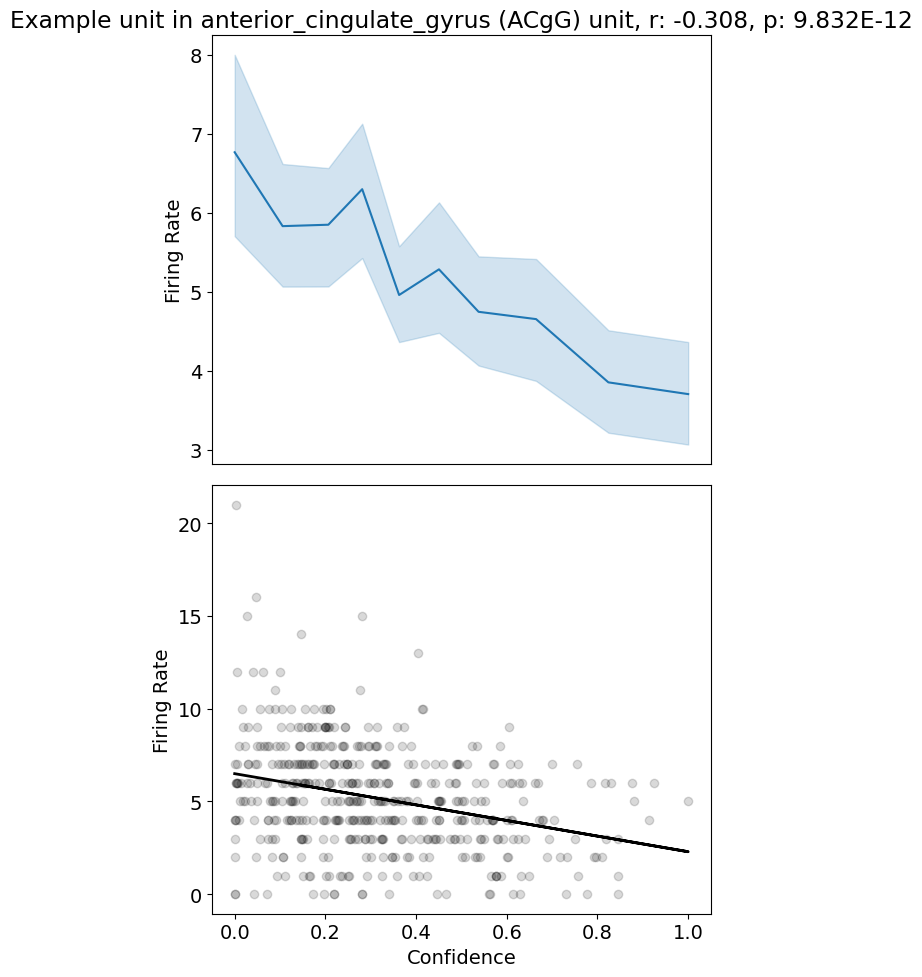

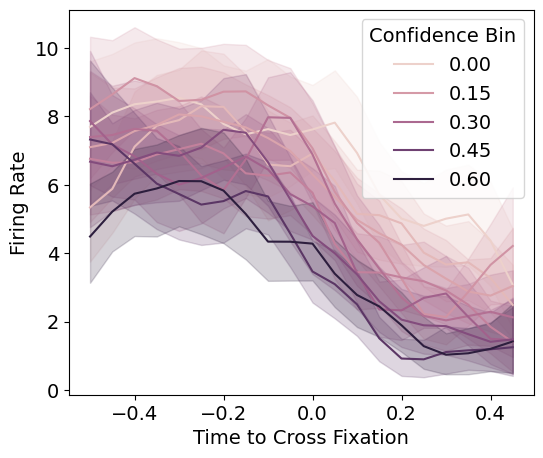

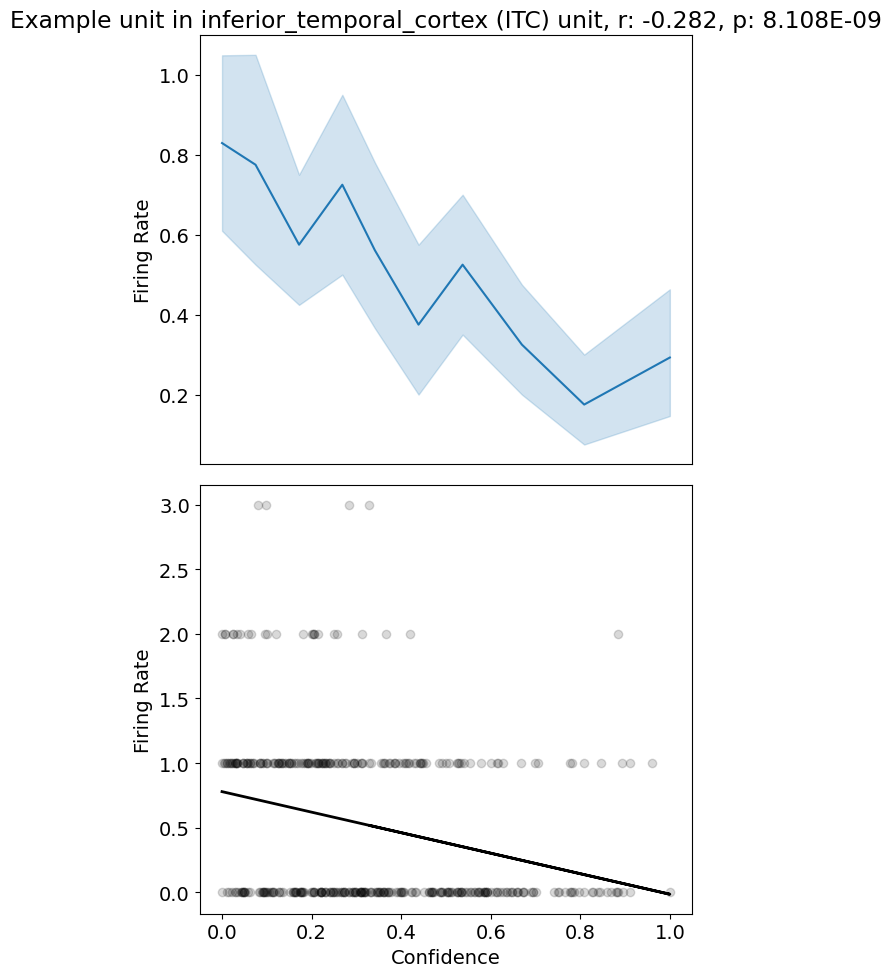

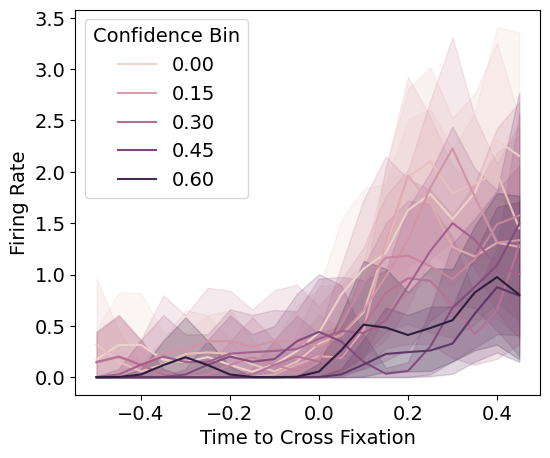

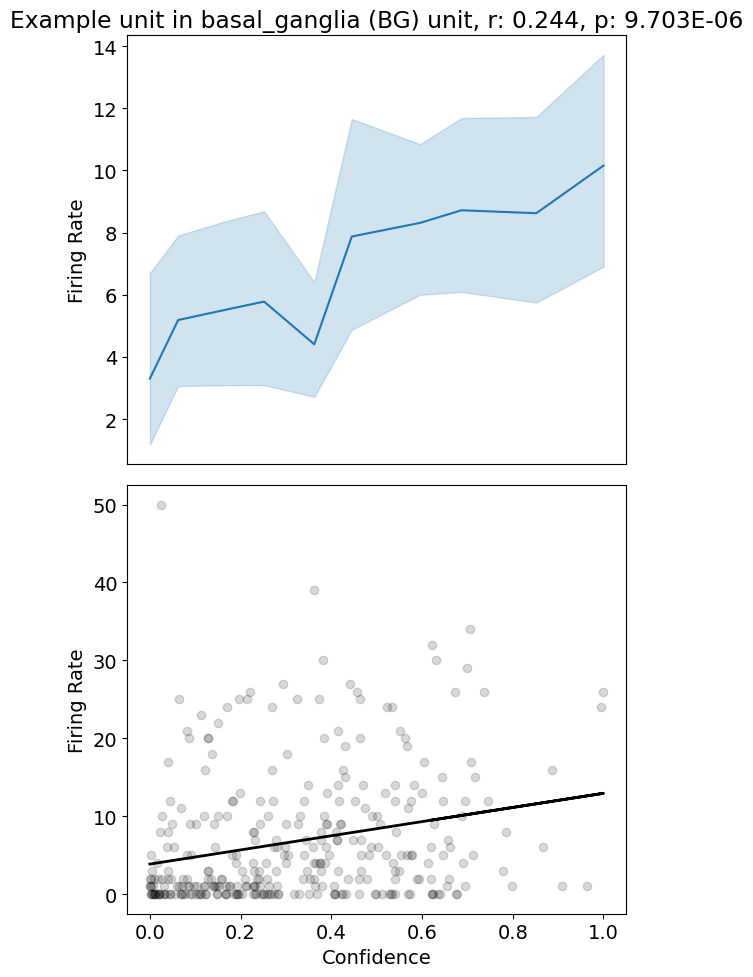

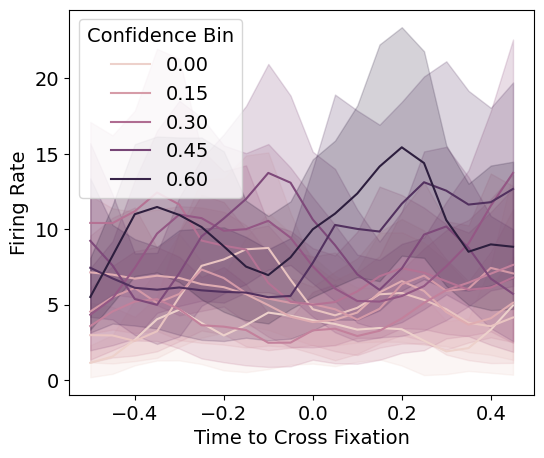

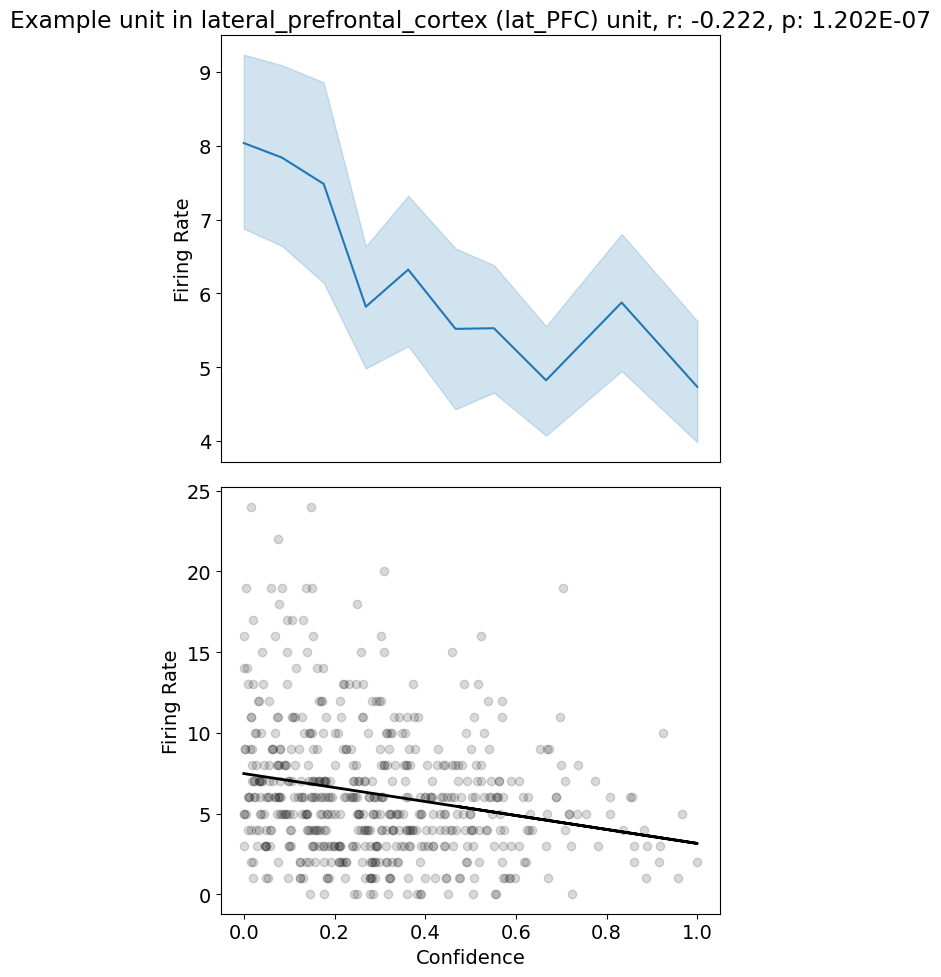

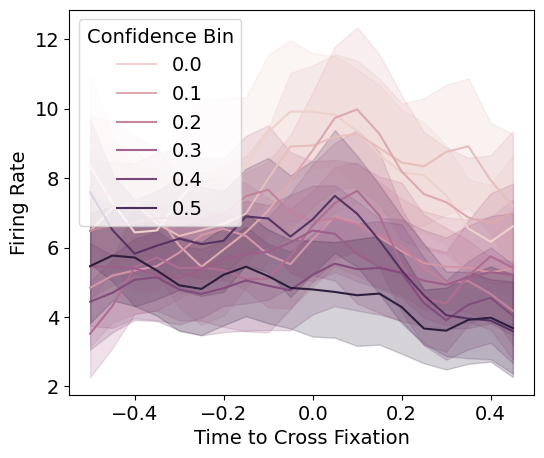

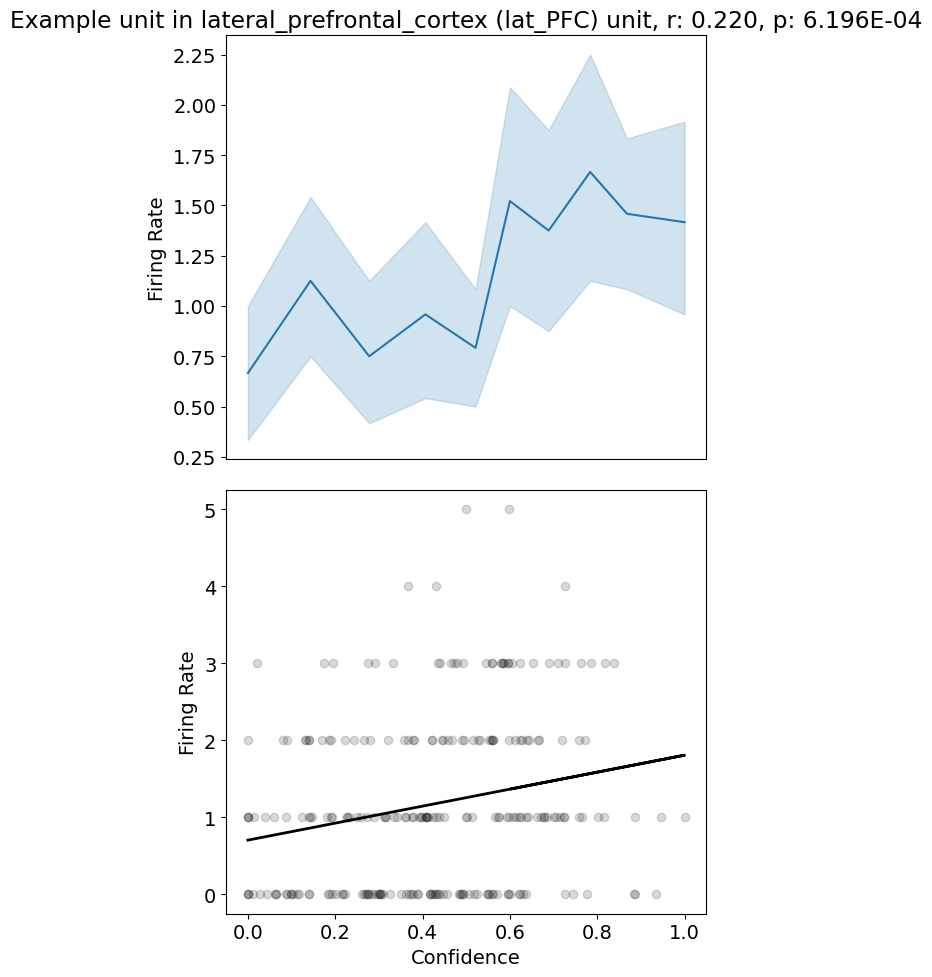

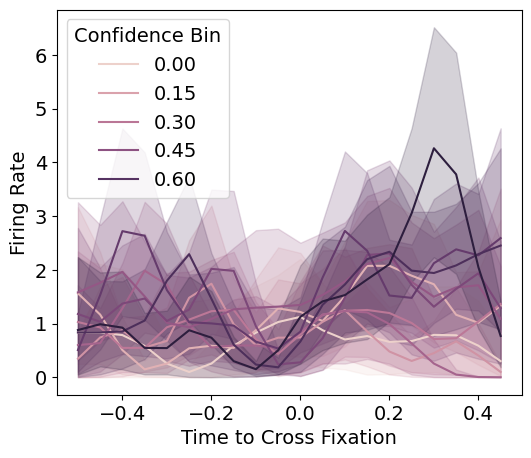

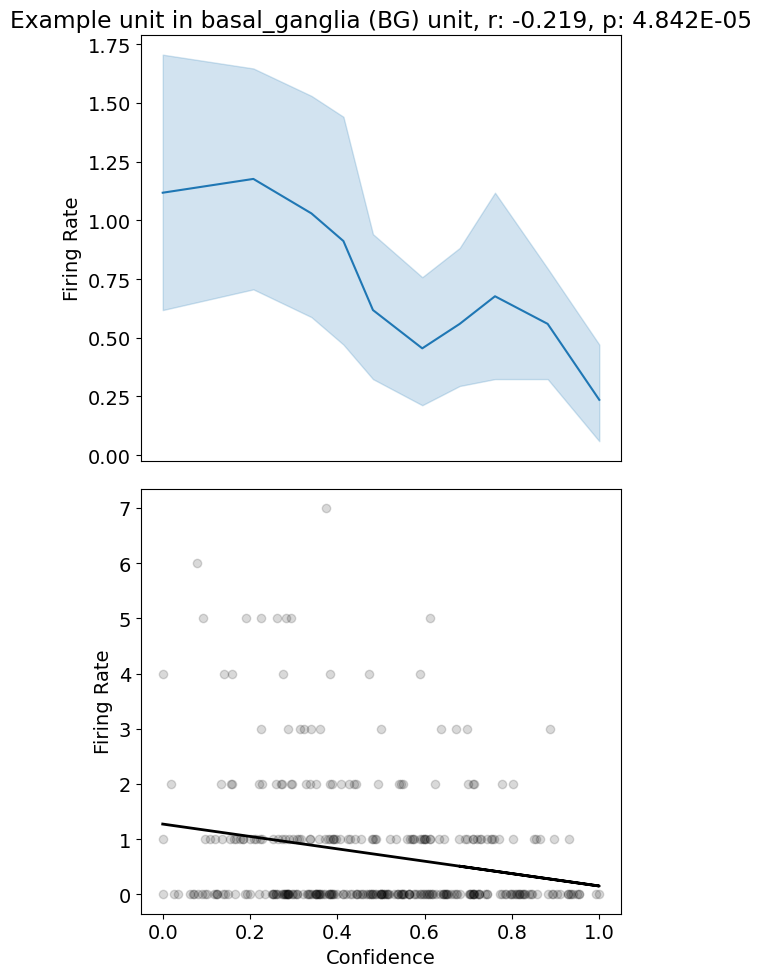

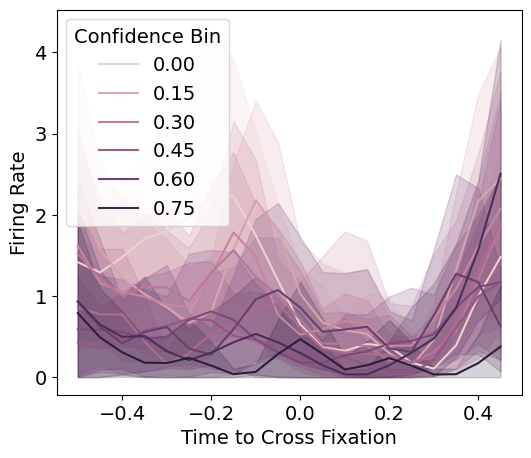

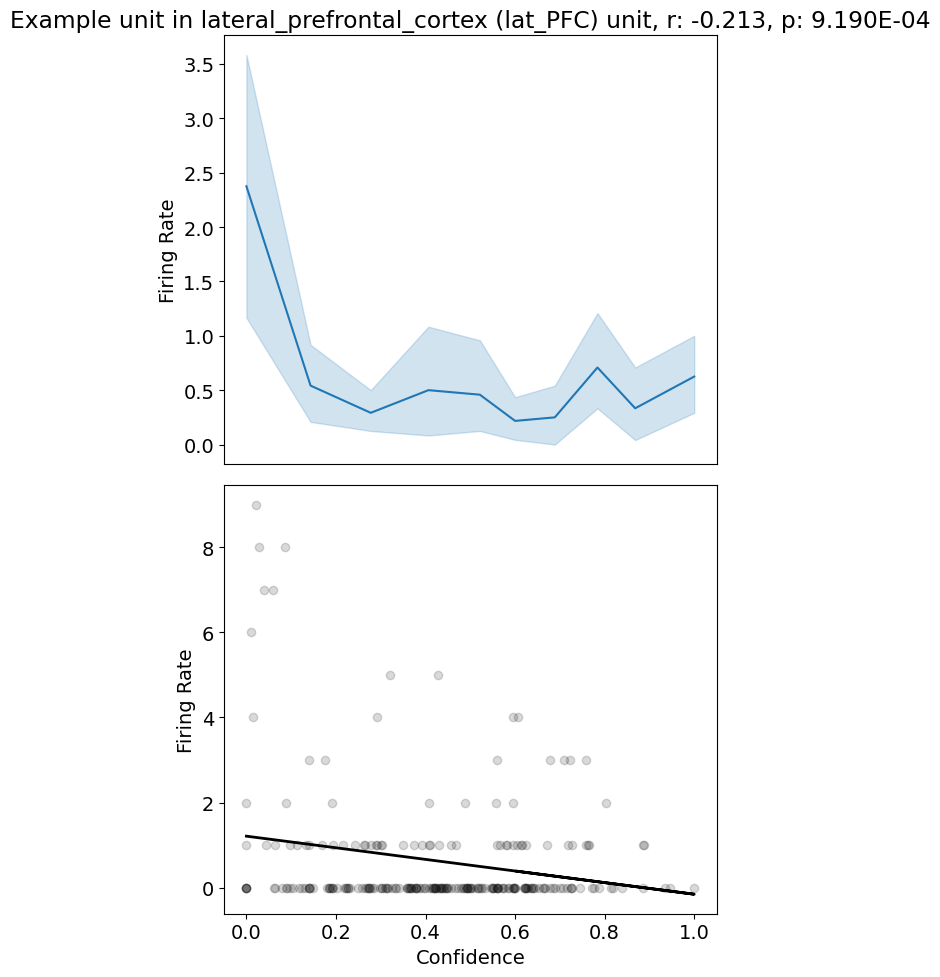

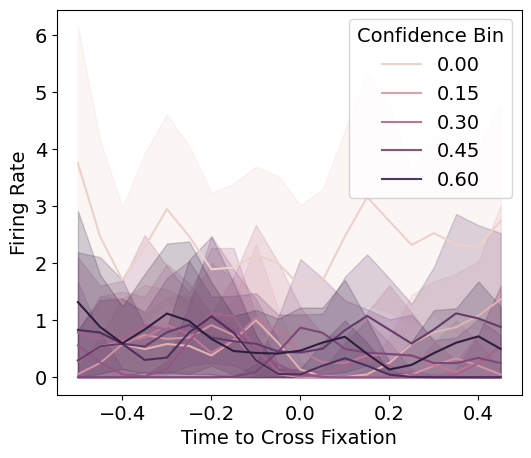

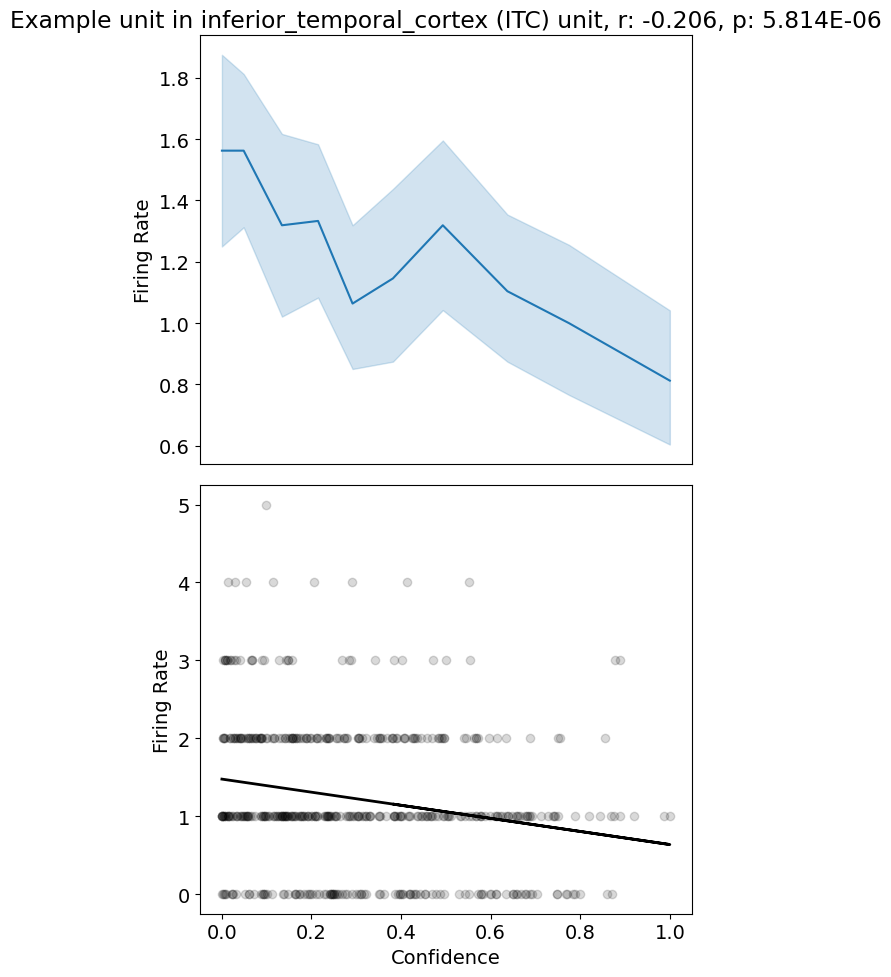

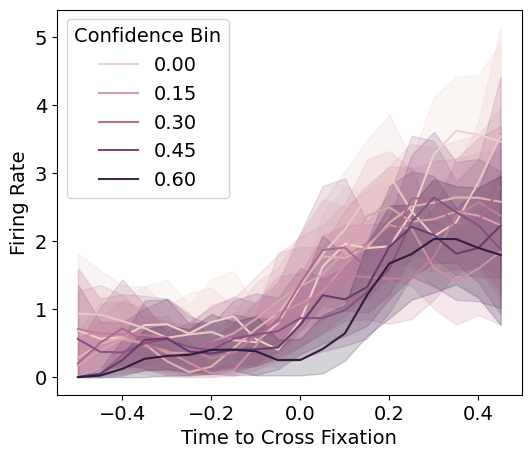

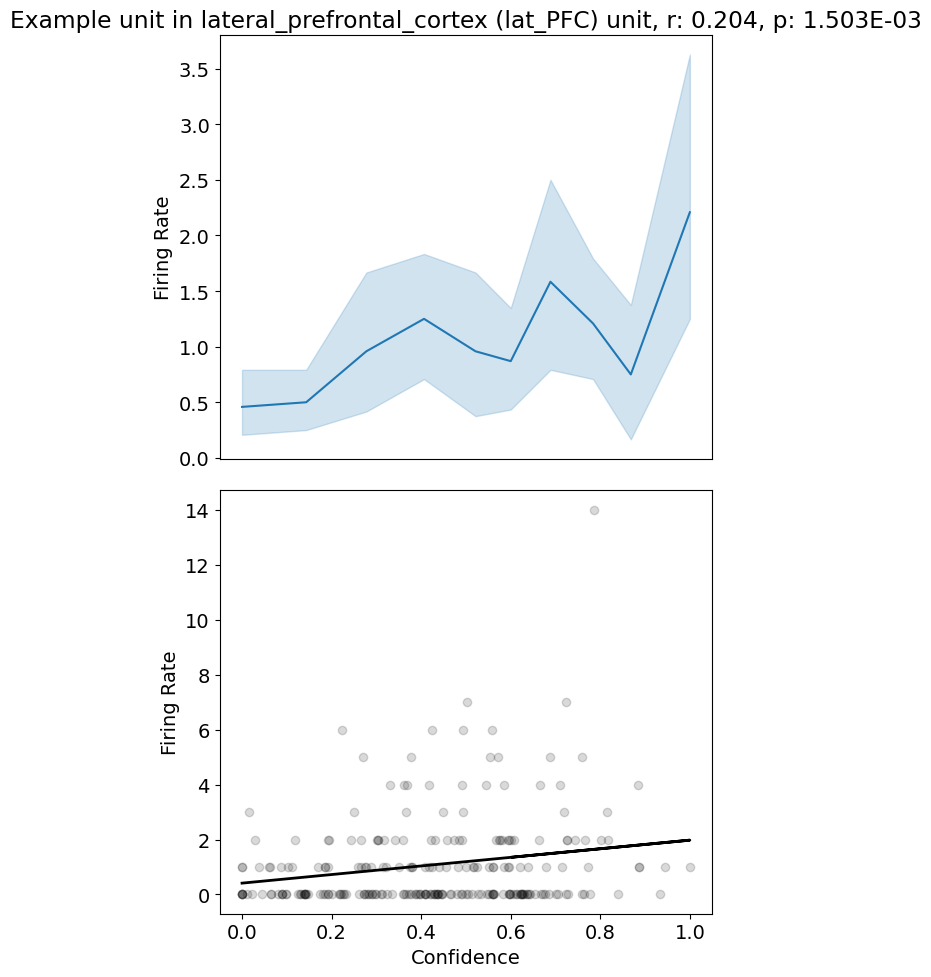

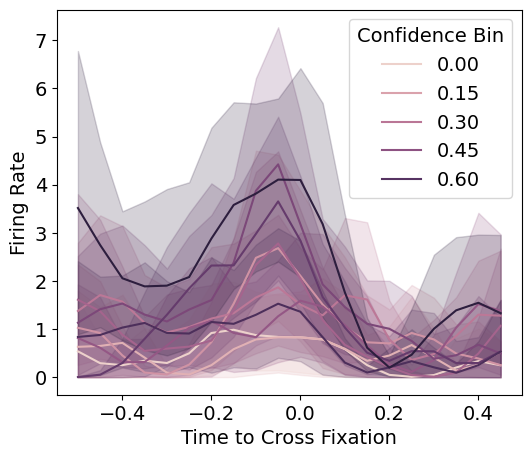

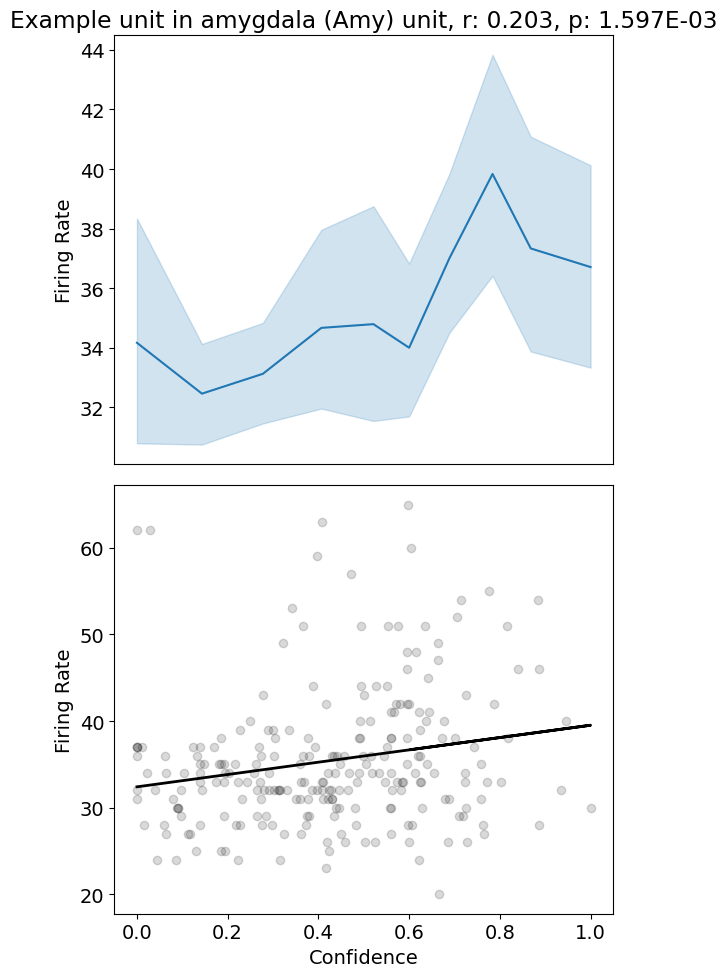

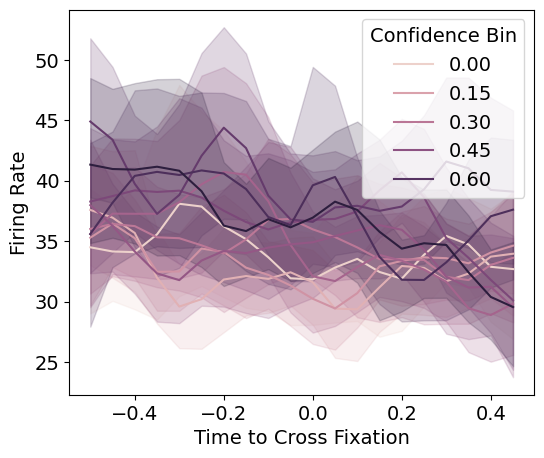

In [26]:
top = correlations.sort_values(by="r_mag", ascending=False)[:10]
# top_20 = merged[(merged.structure_level2 == "inferior_temporal_cortex (ITC)") & ()]
for i, row in top.iterrows():
    visualize_correlations(row, by_dims=False)